In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from exp.nb_Tesis import *
from fastai import *

# Download & Load Data

In [2]:
# !wget https://challenge.kitware.com/api/v1/item/584ad09dcad3a51cc66c8e15/download

In [3]:
# !wget https://challenge.kitware.com/api/v1/item/5849dadccad3a51cc66c8e08/download

In [4]:
path_all_images = Path('./2017/data/')

In [5]:
# name_folder_train = 'ISIC-2017_Training_Data'
# name_folder_valid = 'ISIC-2017_Validation_Data'

name_folder_train = 'train_small_224'
name_folder_valid = 'valid_small_224'


path_train_images = path_all_images / name_folder_train
path_valid_images = path_all_images / name_folder_valid

In [6]:
path_train_ground_truth = Path('2017/train_gt.csv')
path_valid_ground_truth = Path('2017/valid_gt.csv')

# path_test_images = Path('segmented_images/square/ISIC2018_Task3_Test_Input/')

In [7]:
dfTrain = pd.read_csv(path_train_ground_truth); print(f'{len(dfTrain)} train images: ')
dfValid = pd.read_csv(path_valid_ground_truth); print(f'{len(dfValid)} valid images: ')

dfAll = pd.concat([dfTrain,dfValid])

dfSingleLabel = pd.DataFrame({'image_id':dfAll['image_id'] })
dfSingleLabel['label'] = pd.np.where(dfAll['melanoma']==1.0, 'mel','other')
dfSingleLabel.head()

2000 train images: 
150 valid images: 


,image_id,label
0,ISIC_0000000,other
1,ISIC_0000001,other
2,ISIC_0000002,mel
3,ISIC_0000003,other
4,ISIC_0000004,mel


In [8]:
dfSingleLabel.groupby('label').count()

,image_id
label,
mel,404
other,1746


In [9]:
labels_for_2017_live_challenge = ['melanoma', 'nv', 'seborrheic_keratosis']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image_id']==image_name].label)[0]

def get_label_for_image_path(image_path): 
    return get_label_for_image_name(image_path.name[:-4])

In [10]:
get_label_for_image_path(Path('2017/ISIC-2017_Training_Data/ISIC_0000010.jpg'))

'other'

In [11]:
def random_seed(seed_value, use_cuda):  #gleaned from multiple forum posts
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: torch.cuda.manual_seed_all(seed_value) # gpu 

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# Create Databunch

In [14]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1,max_warp=0.2)

data = ImageList.from_folder(path_all_images)\
.split_by_folder(train=name_folder_train, valid=name_folder_valid)\
.label_from_func(get_label_for_image_path)\
.transform(tfms, size=224)\
.databunch(bs=16)\
.normalize()

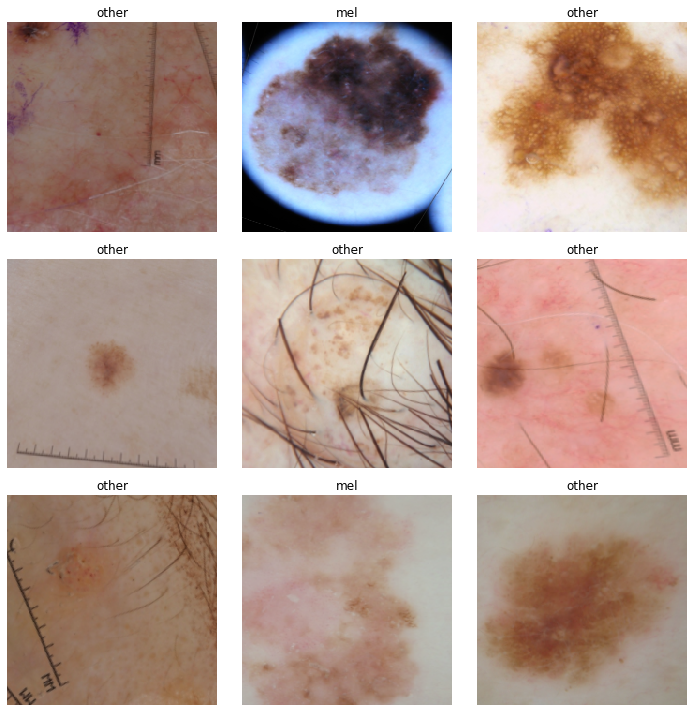

In [65]:
data.show_batch(rows=3, figsize=(10,10))

In [15]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print(train_count,'\n\n', valid_count)

other    1626
mel       374
dtype: int64 

 other    120
mel       30
dtype: int64


In [16]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

233

# Create Learner

In [76]:
random_seed(7,True)
# x50 = lambda x: xresnet50()resnet14
learn = cnn_learner(data,models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    pretrained=True
                    )

In [77]:
# learn.load('bestmodel')
# learn.lr_find()

## Train model's head

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.153127,0.948025,0.313333,0.686667,0.640556,00:17
1,0.646825,0.518993,0.213333,0.786667,0.742222,00:17
2,0.505967,0.528656,0.200000,0.800000,0.704722,00:17
3,0.438659,0.436856,0.173333,0.826667,0.755556,00:18
4,0.417040,0.432086,0.160000,0.840000,0.776944,00:17


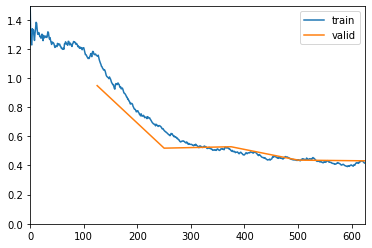

Better model found at epoch 0 with valid_loss value: 0.9480249881744385.
Better model found at epoch 1 with valid_loss value: 0.5189933776855469.
Epoch 2: reducing lr to 0.0003661576968654393
Better model found at epoch 3 with valid_loss value: 0.4368562698364258.
Better model found at epoch 4 with valid_loss value: 0.4320859909057617.


In [78]:
random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
    ReduceLROnPlateauCallback(learn=learn)
])

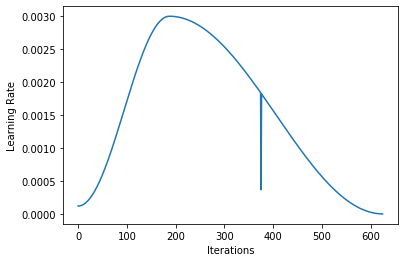

In [79]:
learn.recorder.plot_lr()

## Unfreeze & finetune

In [83]:
learn.save('stage-1')

In [89]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
other,other,other,other,other
Path: 2017/data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
other,other,other,mel,other
Path: 2017/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [80]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.31E-06


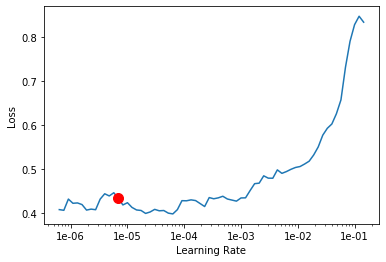

In [81]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

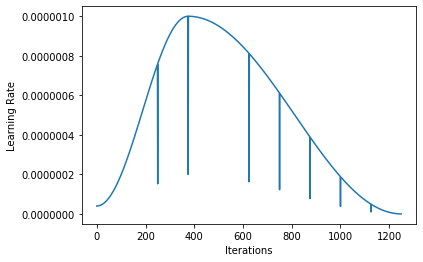

In [85]:
learn.recorder.plot_lr()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.328587,0.480476,0.173333,0.826667,0.769444,00:21
1,0.284038,0.645438,0.206667,0.793333,0.685556,00:22
2,0.301644,0.579188,0.200000,0.800000,0.645833,00:21
3,0.377306,0.439329,0.160000,0.840000,0.791945,00:21
4,0.424940,0.429893,0.160000,0.840000,0.780833,00:21
5,0.414981,0.389114,0.160000,0.840000,0.833333,00:21
6,0.377368,0.367768,0.166667,0.833333,0.856111,00:21
7,0.355294,0.336568,0.146667,0.853333,0.871945,00:21
8,0.313380,0.354647,0.166667,0.833333,0.879167,00:21
9,0.307902,0.347661,0.153333,0.846667,0.871111,00:21


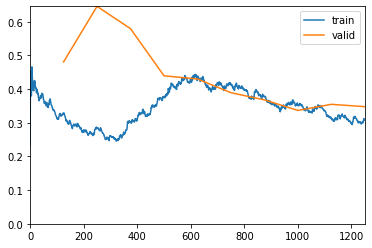

Better model found at epoch 0 with valid_loss value: 0.48047566413879395.
Better model found at epoch 3 with valid_loss value: 0.43932855129241943.
Better model found at epoch 4 with valid_loss value: 0.42989349365234375.
Better model found at epoch 5 with valid_loss value: 0.38911449909210205.
Better model found at epoch 6 with valid_loss value: 0.3677684962749481.
Better model found at epoch 7 with valid_loss value: 0.33656758069992065.


In [90]:
random_seed(7,True)
learn.fit_one_cycle(10, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [91]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

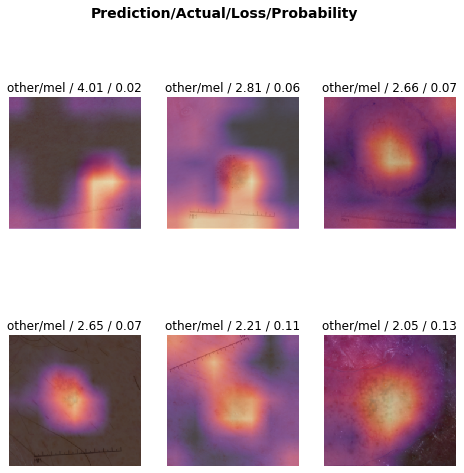

In [92]:
interp.plot_top_losses(6, figsize=(8,8),heatmap=True)

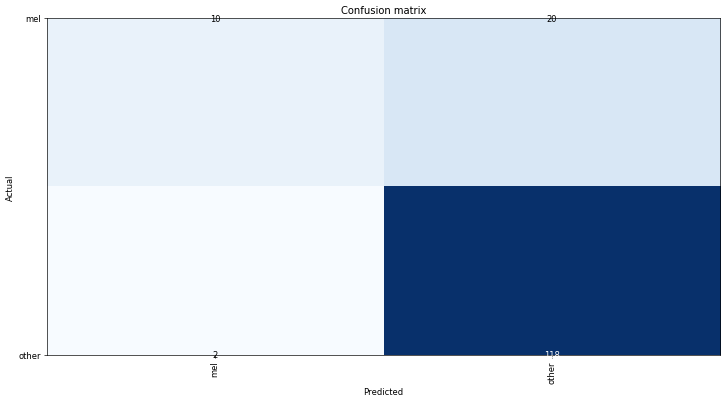

In [93]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [94]:

def get_balanced_accurracy(a_confusion_matrix):
  balanced_acc = 0
  for i in range(len(matrix[0])):
    row = matrix[i]
    correctGuesses = row[i]
    allPossibleTries = row.sum()
    classAcurracy = correctGuesses / allPossibleTries
    balanced_acc += classAcurracy
#     print(classAcurracy)
  balanced_acc /= len(matrix[0])
  return balanced_acc



matrix = interp.confusion_matrix()
"average acc: ", get_balanced_accurracy(matrix)


('average acc: ', 0.6583333333333333)

# Attention

In [70]:
from fastai.vision import *

In [71]:
import types

from torchvision.models.resnet import Bottleneck

In [72]:
def attn_forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

            
        out = out + (identity * self.softmaxLayer(out) * self.alpha) + identity

        out = self.relu(out)

        return out

def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( attn_forward,a_module)
    
def add_attn_params(a_module):
    print(f'Adding attention to {a_module}')
    a_module.softmaxLayer = nn.Softmax2d();
    a_module.alpha = nn.Parameter(torch.ones(1) / 10000)
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [73]:
resnet50_with_attn = models.resnet50(pretrained=True)
apply_leaf(resnet50_with_attn, change_basic_blocks)

Adding attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Adding attention to Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3)

In [74]:
a = list(resnet50_with_attn.modules())[0]

In [75]:
bn = a.layer1[0]

In [76]:
# bn.forward??

In [77]:
ps = list(resnet50_with_attn.named_parameters())

In [78]:
[n for n in ps if n[0] == 'layer1.0.alpha']

[('layer1.0.alpha', Parameter containing:
  tensor([1.0000e-04], requires_grad=True))]

In [79]:
def mock_arch_init(params): 
  return resnet50_with_attn

In [80]:
random_seed(7,True)
# x50 = lambda x: xresnet50()resnet14
learn = cnn_learner(data,mock_arch_init, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ], 
                    
                    )

In [81]:
# del learn
# del data

torch.cuda.empty_cache()
gc.collect()

1924

In [82]:
# learn.load('bestmodel')
# learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.149598,1.042174,0.300000,0.700000,0.602778,00:22
1,0.635876,0.584937,0.213333,0.786667,0.708333,00:22
2,0.503747,0.558037,0.220000,0.780000,0.675278,00:22
3,0.424099,0.454855,0.186667,0.813333,0.741667,00:22
4,0.407141,0.441057,0.186667,0.813333,0.767778,00:22


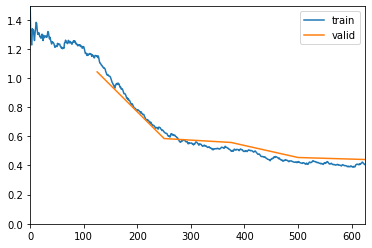

Better model found at epoch 0 with valid_loss value: 1.042173981666565.
Better model found at epoch 1 with valid_loss value: 0.584936797618866.
Better model found at epoch 2 with valid_loss value: 0.5580366253852844.
Better model found at epoch 3 with valid_loss value: 0.4548552334308624.
Better model found at epoch 4 with valid_loss value: 0.44105732440948486.


In [83]:
random_seed(7,True)
learn.fit_one_cycle(5,max_lr=3e-3, callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [84]:
a = list(resnet50_with_attn.modules())[0]

bn = a.layer1[0]

In [86]:
assert not bn.alpha.requires_grad

In [87]:
learn.unfreeze()

In [88]:
assert bn.alpha.requires_grad

In [ ]:
learn.recorder.plot()


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.333736,0.456855,0.180000,0.820000,0.774445,00:29
1,0.235786,0.560934,0.180000,0.820000,0.725556,00:29
2,0.162909,0.700009,0.180000,0.820000,0.771389,00:28
3,0.174062,0.662847,0.213333,0.786667,0.724444,00:28
4,0.406997,0.548627,0.193333,0.806667,0.749722,00:28


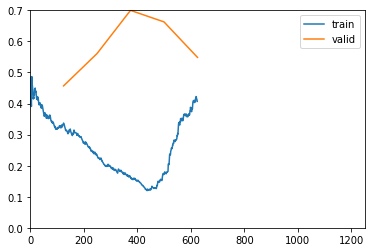

Better model found at epoch 0 with valid_loss value: 0.4568549692630768.


In [ ]:
random_seed(7,True)
learn.fit_one_cycle(10, wd=1e-06, max_lr=slice(1e-05,1e-03),callbacks = [
    SaveModelCallback(learn=learn),
#     ReduceLROnPlateauCallback(learn=learn)
])

In [333]:
learn.activation_stats.stats.shape

torch.Size([2, 110, 2375])

In [338]:
m = list(learn.model.modules())

In [386]:
ps = list(learn.model.named_parameters())

In [388]:
[n[0] for n in ps]

['0.0.weight',
 '0.1.weight',
 '0.1.bias',
 '0.4.0.conv1.weight',
 '0.4.0.bn1.weight',
 '0.4.0.bn1.bias',
 '0.4.0.conv2.weight',
 '0.4.0.bn2.weight',
 '0.4.0.bn2.bias',
 '0.4.0.conv3.weight',
 '0.4.0.bn3.weight',
 '0.4.0.bn3.bias',
 '0.4.0.downsample.0.weight',
 '0.4.0.downsample.1.weight',
 '0.4.0.downsample.1.bias',
 '0.4.1.conv1.weight',
 '0.4.1.bn1.weight',
 '0.4.1.bn1.bias',
 '0.4.1.conv2.weight',
 '0.4.1.bn2.weight',
 '0.4.1.bn2.bias',
 '0.4.1.conv3.weight',
 '0.4.1.bn3.weight',
 '0.4.1.bn3.bias',
 '0.4.2.conv1.weight',
 '0.4.2.bn1.weight',
 '0.4.2.bn1.bias',
 '0.4.2.conv2.weight',
 '0.4.2.bn2.weight',
 '0.4.2.bn2.bias',
 '0.4.2.conv3.weight',
 '0.4.2.bn3.weight',
 '0.4.2.bn3.bias',
 '0.5.0.conv1.weight',
 '0.5.0.bn1.weight',
 '0.5.0.bn1.bias',
 '0.5.0.conv2.weight',
 '0.5.0.bn2.weight',
 '0.5.0.bn2.bias',
 '0.5.0.conv3.weight',
 '0.5.0.bn3.weight',
 '0.5.0.bn3.bias',
 '0.5.0.downsample.0.weight',
 '0.5.0.downsample.1.weight',
 '0.5.0.downsample.1.bias',
 '0.5.1.conv1.weight',
 '

In [384]:
it

<generator object Module.named_parameters at 0x7ff1daf18850>